In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

import water
import mmw
import antoine

tmin = 0.0
dt   = 1.0

%matplotlib inline

In [2]:
def write_csv(gas,ts,hs):
    X = np.array([ts,hs]).T 
    head = "T [K] , delta-h [J kg-1]"
    fpath = "lv/dat/%s.csv"%gas 

    np.savetxt(fpath, X, fmt="%.9e", delimiter=',', header=head)

In [3]:
# Coker (2007) gases (vapourisation only)
data_vap = np.loadtxt("lv/web/coker2007_appendixC.csv", delimiter=',', dtype=str, skiprows=1)

table = mmw.read_elements()

# Row by row
for row in data_vap:

    # get values
    formula = row[0]
    name    = row[1]
    fit_A   = float(row[2])
    fit_T   = float(row[3])
    fit_n   = float(row[4])
    Tmin    = float(row[5])
    Tmax    = float(row[6])

    # define fit 
    def _fit(t:float):
        t = max(t, Tmin)
        t = min(t, Tmax)
        out = fit_A * (1 - t/fit_T)**fit_n # kJ/mol
        out = out * 1e3 / mmw.from_formula(formula, table)  # J/kg
        return out 
    
    t_arr = np.arange(tmin, Tmax+dt, dt)
    
    h_arr = [_fit(t) for t in t_arr]
    write_csv(formula, t_arr, h_arr)


{'H': 1.008, 'He': 4.002, 'Li': 6.94, 'Be': 9.012, 'B': 10.81, 'C': 12.011, 'N': 14.007, 'O': 15.999, 'F': 18.998, 'Ne': 20.1797, 'Na': 22.989, 'Mg': 24.305, 'Al': 26.981, 'Si': 28.085, 'P': 30.973, 'S': 32.06, 'Cl': 35.45, 'Ar': 39.95, 'K': 39.0983, 'Ca': 40.078, 'Sc': 44.955, 'Ti': 47.867, 'V': 50.9415, 'Cr': 51.9961, 'Mn': 54.938, 'Fe': 55.845, 'Co': 58.933, 'Ni': 58.6934, 'Cu': 63.546, 'Zn': 65.38, 'Ga': 69.723, 'Ge': 72.63, 'As': 74.921, 'Se': 78.971, 'Br': 79.904, 'Kr': 83.798, 'Rb': 85.4678, 'Sr': 87.62, 'Y': 88.905, 'Zr': 91.224, 'Nb': 92.906, 'Mo': 95.95, 'Ru': 101.07, 'Rh': 102.905, 'Pd': 106.42, 'Ag': 107.8682, 'Cd': 112.414, 'In': 114.818, 'Sn': 118.71, 'Sb': 121.76, 'Te': 127.6, 'I': 126.904, 'Xe': 131.293, 'Cs': 132.905, 'Ba': 137.327, 'La': 138.905, 'Ce': 140.116, 'Pr': 140.907, 'Nd': 144.242, 'Sm': 150.36, 'Eu': 151.964, 'Gd': 157.25, 'Tb': 158.925, 'Dy': 162.5, 'Ho': 164.93, 'Er': 167.259, 'Tm': 168.934, 'Yb': 173.045, 'Lu': 174.9668, 'Hf': 178.486, 'Ta': 180.947, 'W':

In [4]:
# Constant gases [kJ/mol] from NIST
const_h = {
    "N2O": 16.5,    # Atake and Chihara, 1974
    "SO2": 24.9,    # Giauque and Stephenson, 1938, 2
}

for gas in const_h.keys():
    h = const_h[gas] * 1e3 / mmw.from_formula(gas, table)
    write_csv(gas, [0.0, antoine.gases[gas]["T_crit"]], [h,h])

In [5]:
# Water
t_arr = np.arange(tmin, water.T_crit, dt)
t_arr = np.concatenate((t_arr, [water.T_crit]))
h_arr = [water.delta_both(t) for t in t_arr]
write_csv("H2O",t_arr, h_arr)

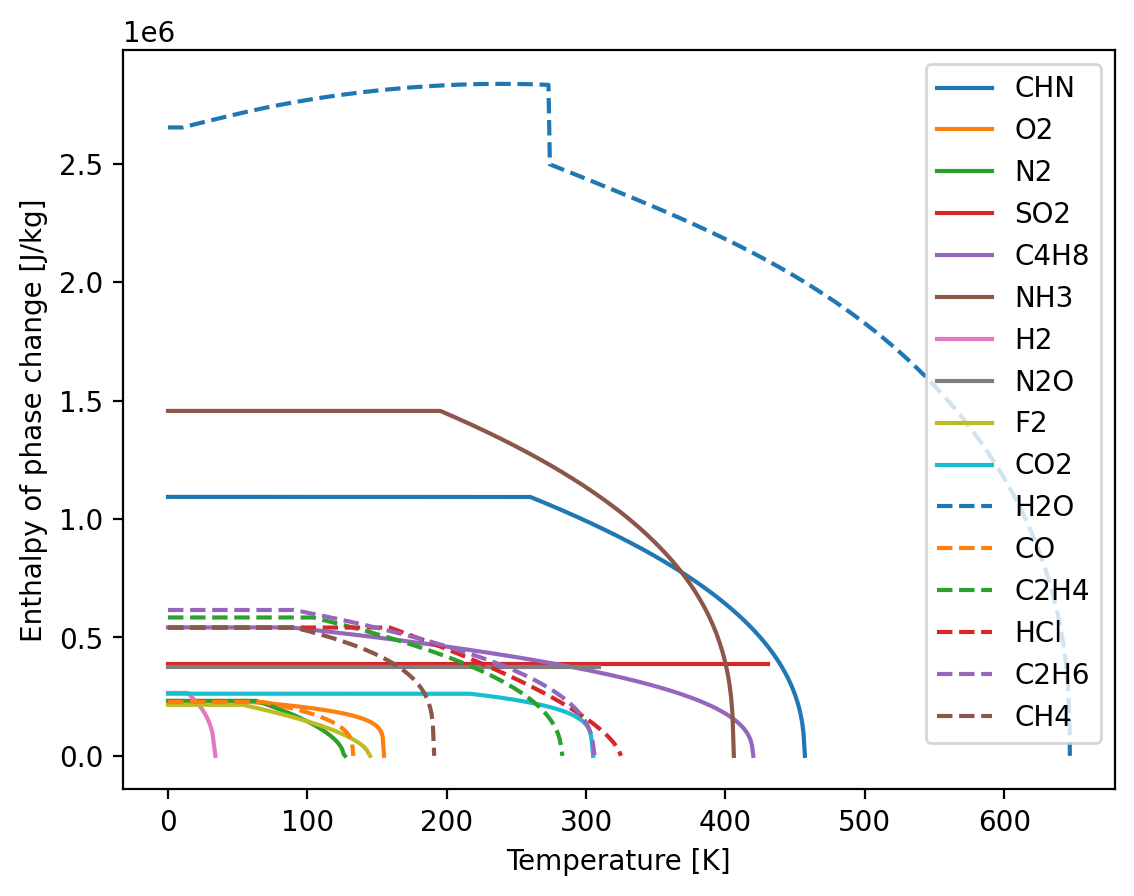

In [6]:
plt.close("all")


fig,ax = plt.subplots(1,1)

files = glob.glob("lv/dat/*.csv")

for i,f in enumerate(files):
    form = mmw.formula_from_path(f)
    data = np.loadtxt(f, delimiter=',').T

    ls='solid'
    if i > 9:
        ls='dashed'
    if i > 18:
        ls='dotted'

    ax.plot(data[0], data[1], label=form, ls=ls)

ax.set(xlabel="Temperature [K]", ylabel="Enthalpy of phase change [J/kg]")
ax.legend()

plt.show()